# PADL Practical 1: Linear regression

## Linear regression in scikit-learn

We'll be using [scikit-learn](https://scikit-learn.org/stable/), [NumPy](https://numpy.org) and [matplotlib](https://matplotlib.org/). You can expect to be consulting the documentation on these libraries on a regular basis.

Begin by reading the scikit-learn [introduction to linear regression](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)  (up to and including Section 1.1.1 on Ordinary Least Squares). Note the comment on feature independence vs. multicollinearity, then try to run the following 4 lines of code copied from that page:

In [123]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2])

LinearRegression()

The two arguments of reg.fit() describe three data points in terms of the values of a pair of independent ('input') variables, and the corresponding target values (the 'output'). Can you identify which is which?

In [124]:
reg.coef_

array([0.5, 0.5])

In [125]:
reg.intercept_

1.1102230246251565e-16

The above 2 lines of code display between them the 3 coefficients you need to define the output as a linear function of the two input variables.

*   Can you now spell out the linear function y=f(x1,x2)?
*   Is it possible to simplify f(**x**), and if so, how and why?




Now we'll move on to another example borrowed the scikit-learn web site (along with some of the text).
The example below uses only the first feature of the **diabetes** dataset, in order to illustrate the data points within the two-dimensional plot. The straight line can be seen in the plot, showing how linear regression attempts to draw a straight line that will best minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation.

The coefficients, residual sum of squares and the coefficient of determination are also calculated.

Read through the code and comments to understand what it does. This may take a while. Here is a hint:

 **diabetes_X = diabetes.data[:, np.newaxis, 2]**

What we are doing here is selecting every row of **diabetes.data** using “**:**” but only the values from the column with index 2. Without the **np.newaxis** we would end up with a vector (since a single column has one dimension), but we want a matrix. The **np.newaxis** achieves this. You can add a line **print(diabetes_X.shape)** to see the number of rows and columns of the resulting matrix.



Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


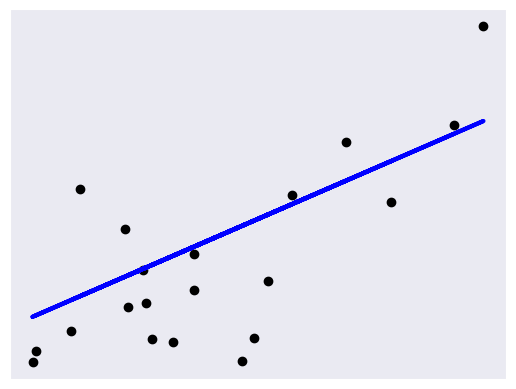

In [126]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

# This line is needed to use matplotlib in Jupyter notebook
%matplotlib inline

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination:
#   1 is perfect prediction
#   0 is as good as always predicting the mean output value (using the training data).
#   negative values are for a model that is worse than just predicting the mean.
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

**Different train/test splits**

The example you have downloaded reserves 20 datapoints for testing. Alter the example so that 10, 20, 40, 100 and 200 datapoints are put aside for testing (so 5 different training data sets are used in turn). Do the R-squared values improve as more data is kept for training?

## Linear regression in PyTorch

The linear regression object `linear_model.LinearRegression` in the code above contains an implementation (in the `fit` method) of classical ordinary least squares. When we call `regr.fit(diabetes_X_train, diabetes_y_train)`, it constructs a set of linear equations in matrix form and then solves them using a closed form solution derived from linear algebra (in fact, it just calls `scipy.linalg.lstsq`).

If linear regression (i.e. fitting a linear model with a least squares loss function) is all you want to do, then this is the right way to implement it. It's fast and it guarantees finding the global optimum. But what if you decide you'd like to introduce a nonlinearity into the model when you see it doesn't fit the data very well? Or you decide you'd like to replace sum of squared errors with a different loss function? Maybe something more robust to outliers? The problem is that these variations probably don't have closed form solutions and, if they do, will be very complicated to derive by hand. If you give up on finding a closed form solution and decide to fit the model using gradient descent, you're going to have to compute the derivatives yourself by hand. This is a nightmare!

So, as we did in practical 0, let's see how we can re-implement linear regression using differentiable programming giving us a foundation that could easily be extended to a more complicated model or loss function with barely any extra work.

In [127]:
import torch

# Convert dataset to PyTorch tensors
# Note: Default floating point dtype in PyTorch is torch.float32 so we'll convert
X_train_tensor = torch.from_numpy(np.float32(diabetes_X_train)).float()
Y_train_tensor = torch.from_numpy(np.float32(diabetes_y_train)).unsqueeze(1)
X_test_tensor = torch.from_numpy(np.float32(diabetes_X_test)).float()
Y_test_tensor = torch.from_numpy(np.float32(diabetes_y_test)).unsqueeze(1)

As usual, we import torch and convert our data into PyTorch tensors. By default, every layer in PyTorch operates on 32 bit floats, so we convert to that for ease. The `unsqueeze` operation is just to make the Y values have the same size as the Xs (the Xs are size $n\times 1$ whereas the Ys are just $n$ - the unsqueeze adds the singleton dimension on the end). This is really unimportant (I call it "tensor origami") but you'll get an error without it.

### A minimal implementation

We're going to start with a minimal implementation that looks quite like practical 0. Then we'll do it again in a more flexible form that is generally better for building large, complex models in PyTorch.

Let's start by defining the components of our model. We're going to do this using PyTorch *layers*. These are the basic building blocks of "computational graphs" - i.e. series of computations through which tensors containing data will be passed and which backpropagation can be automatically applied to. The built in layers in PyTorch are defined in `torch.nn`. In this case, we just want a single `Linear` layer that takes one input ($x$) and provides one output ($y$) which is computed via the linear function: $y=ax+b$.

In [128]:
linear = torch.nn.Linear(1, 1)

This has created an instance of the Linear layer with its own parameters ($a$ and $b$ in the equation above) that by default have `requires_grad` set to True (i.e. they will be updated, or learnt, if we start doing optimisation through the layer). By default, the parameters are initialised randomly. We can inspect their initial values ($a$ is called `weight` and $b$ is called `bias`):

In [129]:
print("Weight: %.2f" % linear.weight)
print("Bias: %.2f" % linear.bias)

Weight: -0.87
Bias: 0.38


We're now ready to set up the optimiser. Here, we will use the `parameters` method of the linear layer which returns a list of its optimisable parameters. Also, I have set the learning rate to a value that works ok for this data (i.e. I did the tuning for you - this is a skill you will need to develop later).

In [130]:
optim = torch.optim.SGD(linear.parameters(), lr=0.6)

Now it's time to set up our main training loop and run the optimisation.

In [131]:
epochs = 2000
for epoch in range(epochs):
    # Pass the training x values through the linear layer to get y predictions
    y_predict = linear(X_train_tensor)
    # Compute the loss as mean squared error between predictions and given y
    loss = ((y_predict - Y_train_tensor) ** 2.0).mean()
    # Reset the gradients to zero
    optim.zero_grad()
    # Back propagate from the loss through the layers
    loss.backward()
    # Take a gradient descent step
    optim.step()
    if not epoch % 200:
        # Print out the loss every 200 iterations
        print("epoch {}, loss {}".format(epoch, loss.item()))

epoch 0, loss 29357.51171875
epoch 200, loss 4627.42822265625
epoch 400, loss 4181.43115234375
epoch 600, loss 4031.2568359375
epoch 800, loss 3980.690185546875
epoch 1000, loss 3963.66357421875
epoch 1200, loss 3957.930419921875
epoch 1400, loss 3955.999755859375
epoch 1600, loss 3955.349853515625
epoch 1800, loss 3955.130859375


First let's verify that the optimisation has indeed updated the parameters:

In [132]:
print("Weight: %.2f" % linear.weight)
print("Bias: %.2f" % linear.bias)

Weight: 934.17
Bias: 152.92


The weight should now be very similar to the result from the closed form solution above. Let's check that the error on the predictions is also similar:

In [133]:
y_predict = linear(X_test_tensor)
loss = ((y_predict - Y_test_tensor) ** 2.0).mean()
print("Mean squared error: %.2f" % loss)

Mean squared error: 2552.73


### A more PyTorch solution

Let's see a slightly different version of the same thing above:



In [134]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        # Call superclass constructor
        super(linearRegression, self).__init__()
        # Initialise contents of model - in this case a single linear layer
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        # Forward pass through the model is simply application of linear layer
        y = self.linear(x)
        return y


# Instantiate model
model = linearRegression(1, 1)
# Instantiate loss function
criterion = torch.nn.MSELoss()
# Setup optimiser
optim = torch.optim.SGD(model.parameters(), lr=0.6)

# Main training loop
for epoch in range(epochs):
    y_predict = model(X_train_tensor)
    loss = criterion(y_predict, Y_train_tensor)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 200 iterations
        print("epoch {}, loss {}".format(epoch, loss.item()))

y_predict = model(X_test_tensor)
loss = criterion(y_predict, Y_test_tensor)
print("Mean squared error: %.2f" % loss)

epoch 0, loss 29229.201171875
epoch 200, loss 4624.94482421875
epoch 400, loss 4180.59423828125
epoch 600, loss 4030.974853515625
epoch 800, loss 3980.595458984375
epoch 1000, loss 3963.631103515625
epoch 1200, loss 3957.91943359375
epoch 1400, loss 3955.99609375
epoch 1600, loss 3955.34912109375
epoch 1800, loss 3955.13037109375
Mean squared error: 2552.72


There are only two differences:
1. We put the linear layer inside a `torch.nn.Module` object. This is a neat container for the layers in a model but it has many other benefits that we'll see later. For example, note that this object also has a `parameters()` method which returns a list of all trainable parameters of all layers within the model. You can see that if the model had a more complex structure with many layers, this would be preferable over having to call `parameters()` on every layer and putting them all in a list when setting up the optimiser.
2. We used a built in layer for the mean squared error loss, `torch.nn.MSELoss()`.

### Exercises

1. Introduce an outlier into the training set. i.e. add an extra data point to `X_train_tensor` and `Y_train_tensor` where the x value is similar to the other training data but the y value is orders of magnitudes bigger.


In [135]:
X_train_outlier = X_train_tensor.clone()
X_train_outlier = torch.cat(
    (X_train_outlier, torch.mean(X_train_outlier).reshape((1, 1)))
)
Y_train_outlier = Y_train_tensor.clone()
Y_train_outlier = torch.cat((Y_train_outlier, torch.tensor(100000).reshape((1, 1))))

2. Re-run the linear least squares code as above. Add code to plot the data without the outlier and the line of best fit. How bad is the fit including the outlier?


In [136]:
# Instantiate model
model = linearRegression(1, 1)
# Instantiate loss function
criterion = torch.nn.MSELoss()
# Setup optimiser
optim = torch.optim.SGD(model.parameters(), lr=0.6)

# Main training loop
for epoch in range(epochs):
    y_predict = model(X_train_outlier)
    loss = criterion(y_predict, Y_train_outlier)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 200 iterations
        print("epoch {}, loss {}".format(epoch, loss.item()))

y_predict = model(X_train_outlier)
loss = criterion(y_predict, Y_train_outlier)
print("Mean squared error: %.2f" % loss)

epoch 0, loss 23670458.0
epoch 200, loss 23517108.0
epoch 400, loss 23516662.0
epoch 600, loss 23516512.0
epoch 800, loss 23516460.0
epoch 1000, loss 23516440.0
epoch 1200, loss 23516434.0
epoch 1400, loss 23516436.0
epoch 1600, loss 23516434.0
epoch 1800, loss 23516432.0
Mean squared error: 23516434.00


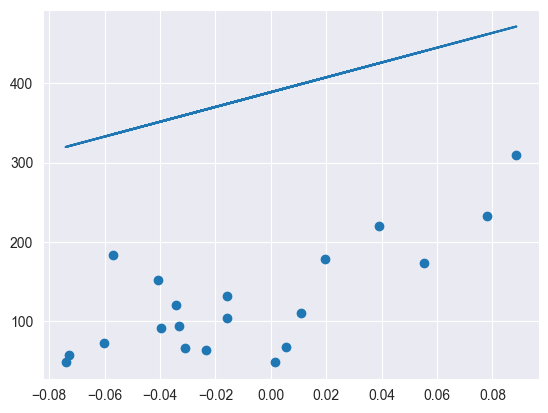

In [137]:
Y_outlier_pred = model(X_test_tensor)
plt.scatter(X_test_tensor, Y_test_tensor)
plt.plot(X_test_tensor, Y_outlier_pred.detach().numpy())

3. Can a different loss function provide robustness to outliers? Take a look at [pytorch.org/docs/stable/nn.html#loss-functions](https://pytorch.org/docs/stable/nn.html#loss-functions) to see the built in loss functions available. L1 (absolute errors rather than squared errors) should be less sensitive to extreme values. Give it a try.

In [145]:
# Instantiate model
model = linearRegression(1, 1)
# Instantiate loss function
criterion = torch.nn.L1Loss()
# Setup optimiser
optim = torch.optim.SGD(model.parameters(), lr=0.6)

# Main training loop
for epoch in range(epochs):
    y_predict = model(X_train_outlier)
    loss = criterion(y_predict, Y_train_outlier)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 200 iterations
        print("epoch {}, loss {}".format(epoch, loss.item()))

y_predict = model(X_train_outlier)
loss = criterion(y_predict, Y_train_outlier)
print("Mean squared error: %.2f" % loss)

epoch 0, loss 388.4710998535156
epoch 200, loss 310.4371337890625
epoch 400, loss 302.4763488769531
epoch 600, loss 301.2091369628906
epoch 800, loss 300.9842834472656
epoch 1000, loss 300.9200744628906
epoch 1200, loss 300.8667907714844
epoch 1400, loss 300.8145446777344
epoch 1600, loss 300.7624816894531
epoch 1800, loss 300.7107849121094
Mean squared error: 300.66


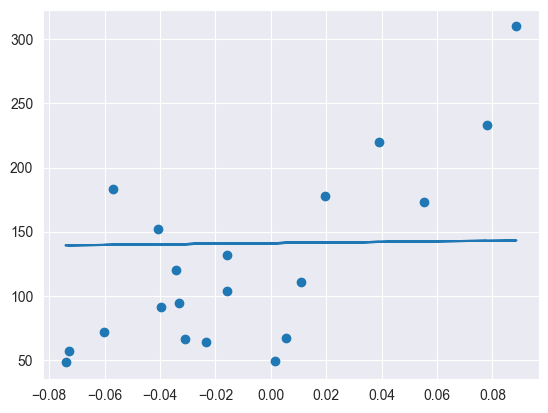

In [146]:
Y_outlier_pred = model(X_test_tensor)
plt.scatter(X_test_tensor, Y_test_tensor)
plt.plot(X_test_tensor, Y_outlier_pred.detach().numpy())